# Collaborative filtering practice

In this homework you will test different collaborative filtering (CF) approaches on famous Movielens dataset.

In class we implemented item2item CF, so this time let's use **user2user** approach.

## Task 0: Dataset (5 points)

Load [movielens](https://grouplens.org/datasets/movielens/) dataset using [scikit surprise](https://surprise.readthedocs.io/en/stable/dataset.html)

Split dataset to train and validation parts.

Don't forget to encode users and items from 0 to maximum!

In [2]:
# https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [633]:
import pandas as pd
from pathlib import Path

ratings = pd.read_csv(Path("ml-latest-small", "ratings.csv"))
movies = pd.read_csv(Path("ml-latest-small", "movies.csv"))
len(ratings), len(movies)

(100836, 9742)

In [634]:
print(f"ratings table cols: {ratings.columns.values}")
print(f"movies table cols: {movies.columns.values}")

ratings table cols: ['userId' 'movieId' 'rating' 'timestamp']
movies table cols: ['movieId' 'title' 'genres']


In [635]:
ratings.loc[:, "rating"].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [636]:
# ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).
# so i would represent 0 as "not evaluated"

In [637]:
import numpy as np

# construct the numpy ndarrays for train and validation (dev)
# because we handle timeseries data (we have 'timestamp')
# let's do the leave-last-few-ratings-out per user split by time 
# and then drop the timestamp column

ratings = ratings.sort_values(by=["userId", "timestamp"]).reset_index(drop=True)

train_data_list = []
dev_data_list = []

for user_id, user_ratings in ratings.groupby("userId"):
    # reserve the last 1 or more ratings for dev_data, use the rest for train_data
    n_dev_ratings = max(1, int(0.2 * len(user_ratings)))
    train_data_list.append(user_ratings.iloc[:-n_dev_ratings])
    dev_data_list.append(user_ratings.iloc[-n_dev_ratings:])

train_data = pd.concat(train_data_list)
dev_data = pd.concat(dev_data_list)

train_data = train_data.drop(columns="timestamp")
dev_data = dev_data.drop(columns="timestamp")

len(train_data), len(dev_data)

(80896, 19940)

In [638]:
from sklearn.preprocessing import LabelEncoder

def ids_encoder(ratings: pd.DataFrame) -> tuple[pd.DataFrame, LabelEncoder, LabelEncoder]:
    users = sorted(ratings["userId"].unique())
    movies = sorted(ratings["movieId"].unique())

    uenc = LabelEncoder().fit(users)
    menc = LabelEncoder().fit(movies)

    ratings["userId"] = uenc.transform(ratings["userId"])
    ratings["movieId"] = menc.transform(ratings["movieId"])

    return ratings, uenc, menc

In [639]:
train_data, uenc, menc = ids_encoder(train_data)
dev_data["userId"] = uenc.transform(dev_data["userId"])

train_data = train_data.to_numpy()
dev_data = dev_data.to_numpy()

## Task 1: Similarities (5 points each)

You need to implement 3 similarity functions:
1. Dot product (intersection)
1. Jaccard index (intersection over union)
1. Pearson correlation
1. Pearson correlation with decreasing coefficient

In [418]:
def sim_dot(left: np.ndarray, right: np.ndarray) -> float:
    '''Dot product similarity

    Args:
        left: first user ratings
        right: second user ratings

    Retruns:
        Similarity score for this pair
    '''
    # assuming that left and right vectors already preprocessed in such way,
    # that it stored only movie ratings, which both users eval
    # (but can either working with sparse vectors)
    sim = left @ right
    return sim

In [419]:
def sim_jacc(left: np.ndarray, right: np.ndarray) -> float:
    '''Jaccard index similarity

    Args:
        left: first user ratings
        right: second user ratings

    Retruns:
        Similarity score for this pair
    '''
    # assuming that left and right vectors are sparse vectors over all movies
    sim = np.sum(left & right) / np.sum(left | right)
    return sim

In [509]:
from scipy.stats import pearsonr

def sim_pearson(left: np.ndarray, right: np.ndarray) -> float:
    '''Pearson correlation similarity

    Args:
        left: first user ratings
        right: second user ratings

    Retruns:
        Similarity score for this pair
    '''
    # assuming that left and right vectors already preprocessed in such way,
    # that it stored only movie ratings, which both users eval
    try:
        sim = pearsonr(left, right)[0]
        return sim
    except ValueError:
        return 0

In [510]:
def sim_pearson_decreasing(left: np.ndarray, right: np.ndarray) -> float:
    '''Pearson correlation similarity which decreases on small intersection

    Args:
        left: first user ratings
        right: second user ratings

    Retruns:
        Similarity score for this pair
    '''
    # assuming that left and right vectors already preprocessed in such way,
    # that it stored only movie ratings, which both users eval
    coef = min(1, left.shape[0] / 50)
    try:
        sim = coef * pearsonr(left, right)[0]
        return sim
    except ValueError:
        return 0

## Task 2: Collaborative filtering algorithm (5 points each)

Now you have several options to use similarities for ratings prediction:
1. Simple averaging
1. Mean corrected averaging

In [ ]:
from tqdm.notebook import trange
from typing import Callable

class UserBasedCf:
    '''User2user collaborative filtering algorithm'''
    def __init__(self, sim_fn: Callable, mean_correct: bool = False) -> None:
        self.sim_fn = sim_fn
        self.mean_correct = mean_correct

    def calc_sim_matrix(self, feedbacks: np.ndarray) -> None:
        '''Fills matrix of user similarities

        Args:
            feedbacks: numpy array with ratings
        '''
        self.feedbacks = feedbacks        

        self.n_users = len(np.unique(feedbacks[:, 0]))
        self.n_movies = len(np.unique(feedbacks[:, 1]))

        self.R = np.zeros(shape=(self.n_users, self.n_movies), dtype=np.float32)
        self.R[feedbacks[:, 0].astype(int), feedbacks[:, 1].astype(int)] = feedbacks[:, 2]

        # mean-correct the ratings
        if self.mean_correct:
            mean_user_ratings = np.true_divide(self.R.sum(1), (self.R != 0).sum(1))
            self.R = self.R - mean_user_ratings[:, np.newaxis]
            self.R[self.R == -mean_user_ratings[:, np.newaxis]] = 0

        self.sim_matrix = np.ones(shape=(self.n_users, self.n_users))

        for u1_i in trange(self.n_users):
            for u2_i in range(u1_i + 1, self.n_users):
                if self.sim_fn.__name__ != "sim_jacc":
                # make intersected vectors
                    mask = np.multiply(self.R[u1_i], self.R[u2_i]) != 0.
                    self.sim_matrix[[u1_i, u2_i], [u2_i, u1_i]] = self.sim_fn(self.R[u1_i, mask], 
                                                                              self.R[u2_i, mask])
                else:
                    self.sim_matrix[[u1_i, u2_i], [u2_i, u1_i]] = self.sim_fn(self.R[u1_i].astype(bool), 
                                                                              self.R[u2_i].astype(bool))

    def recommend(self, user: int, n: int, neighboar_thres: float) -> np.ndarray:
        '''Computes most relevant unseen items for the user

        Args:
            user: user_id for which to provide recommendations
            n: how many items to return
        '''
        # validate user id
        if user >= self.n_users or user < 0:
            raise ValueError("User ID is out of bounds")

        # find neighbors above threshold
        neighbors = np.argwhere(self.sim_matrix[user] > neighboar_thres).ravel()
        if len(neighbors) == 0:
            return np.array([])  # no neighbors above threshold
        
        # find items the user has not seen/rated
        not_seen_ids = np.argwhere(self.R[user] == 0).ravel()
        if len(not_seen_ids) == 0:
            return np.array([])  # user has rated all items

        # include only items rated by neighbors
        neighbor_ratings = self.R[neighbors][:, not_seen_ids]
        possible_movies = not_seen_ids[np.any(neighbor_ratings > 0, axis=0)]
        if len(possible_movies) == 0:
            return np.array([])  # no items are rated by neighbors

        # calc predicted ratings for the filtered possible movies
        R_preds = (self.R[neighbors][:, possible_movies].T @ self.sim_matrix[user, neighbors]) / np.sum(np.abs(self.sim_matrix[user, neighbors]))

        top_recommendations_idx = np.argsort(R_preds)[::-1][:n] 
        recommended = possible_movies[top_recommendations_idx]

        return recommended

This way you have got 6 different recommendation methods (each of two CF modes can be used with 3 similarity scores).

## Task 3: Apply models

1. For all 6 possible algorithm variations train it and compute recomendations for validation part. (10 points)

### Dot product similarity with mean correct

In [640]:
ubcf_dot = UserBasedCf(sim_fn=sim_dot, mean_correct=True)
ubcf_dot.calc_sim_matrix(train_data)

  0%|          | 0/610 [00:00<?, ?it/s]

In [551]:
import matplotlib.pyplot as plt

def plot_pdf(values: np.ndarray, title: str):
    """Plots `values` distribution density"""
    plt.figure(figsize=(10, 5))
    plt.violinplot(values.flatten(), vert=False, showmedians=True)
    plt.xlabel("Similarity")
    plt.grid()
    plt.title(title)
    plt.show()

triangle_mask = np.tri(len(np.unique(train_data[:, 0])), k=-1, dtype=np.bool_)

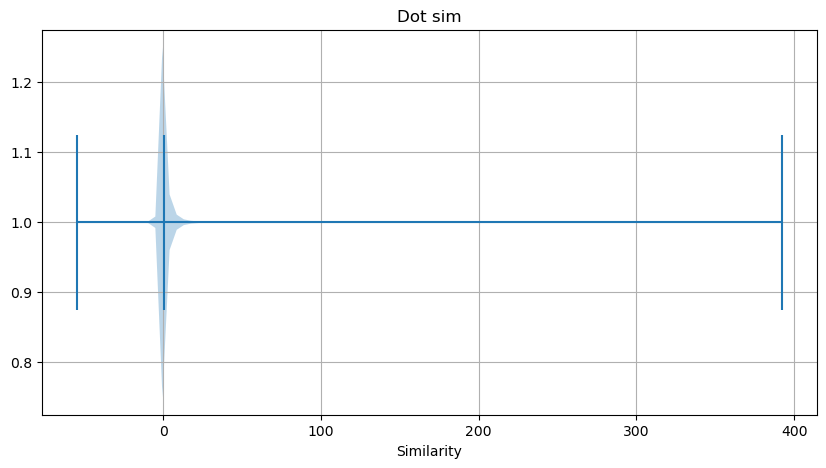

In [641]:
plot_pdf(ubcf_dot.sim_matrix[triangle_mask], "Dot sim")

In [642]:
pd.Series(ubcf_dot.sim_matrix[triangle_mask]).describe()

count    185745.000000
mean          1.676457
std           6.694937
min         -54.670909
25%          -0.110345
50%           0.206044
75%           1.948318
max         392.019517
dtype: float64

In [554]:
from tqdm.notebook import tqdm

# compute recommendations for dev dataset
n_recommendations = 50
dot_neighboar_thres = 5.  # based on plot above

dot_user_recommendations = {}
for user_id in tqdm(np.unique(dev_data[:, 0])):
    recommendations = ubcf_dot.recommend(user=int(user_id), n=n_recommendations, neighboar_thres=dot_neighboar_thres)
    
    recommended_movie_ids = menc.inverse_transform(recommendations)
    dot_user_recommendations[uenc.inverse_transform([int(user_id)])[0]] = recommended_movie_ids

  0%|          | 0/610 [00:00<?, ?it/s]

### Dot product similarity w/o mean correct

In [580]:
ubcf_dot_2 = UserBasedCf(sim_fn=sim_dot, mean_correct=False)
ubcf_dot_2.calc_sim_matrix(train_data)

  0%|          | 0/610 [00:00<?, ?it/s]

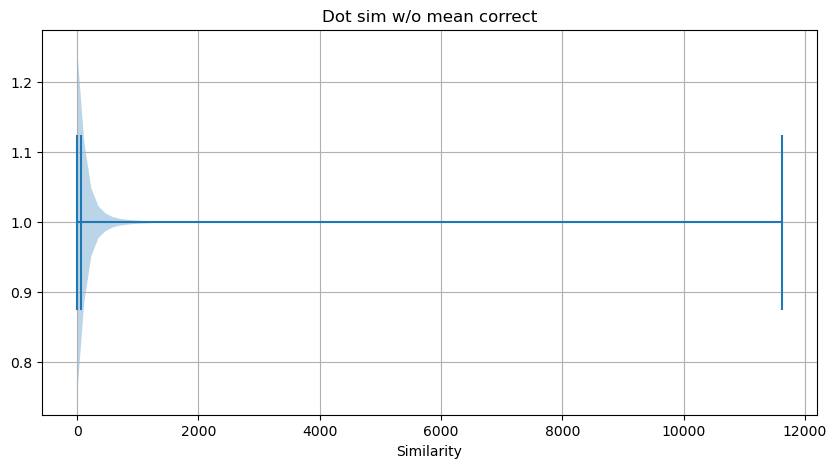

In [581]:
plot_pdf(ubcf_dot_2.sim_matrix[triangle_mask], "Dot sim w/o mean correct")

In [582]:
pd.Series(ubcf_dot_2.sim_matrix[triangle_mask]).describe()

count    185745.000000
mean        165.990320
std         315.867917
min           0.000000
25%          18.000000
50%          68.250000
75%         185.750000
max       11616.500000
dtype: float64

In [583]:
# compute recommendations for dev dataset
n_recommendations = 50
dot_2_neighboar_thres = 100.  # based on plot above

dot_2_user_recommendations = {}
for user_id in tqdm(np.unique(dev_data[:, 0])):
    recommendations = ubcf_dot_2.recommend(user=int(user_id), n=n_recommendations, neighboar_thres=dot_2_neighboar_thres)
    
    recommended_movie_ids = menc.inverse_transform(recommendations)
    dot_2_user_recommendations[uenc.inverse_transform([int(user_id)])[0]] = recommended_movie_ids

  0%|          | 0/610 [00:00<?, ?it/s]

### Jaccard similarity with mean correct

In [501]:
ubcf_jacc = UserBasedCf(sim_fn=sim_jacc, mean_correct=True)
# training
ubcf_jacc.calc_sim_matrix(train_data)

  0%|          | 0/610 [00:00<?, ?it/s]

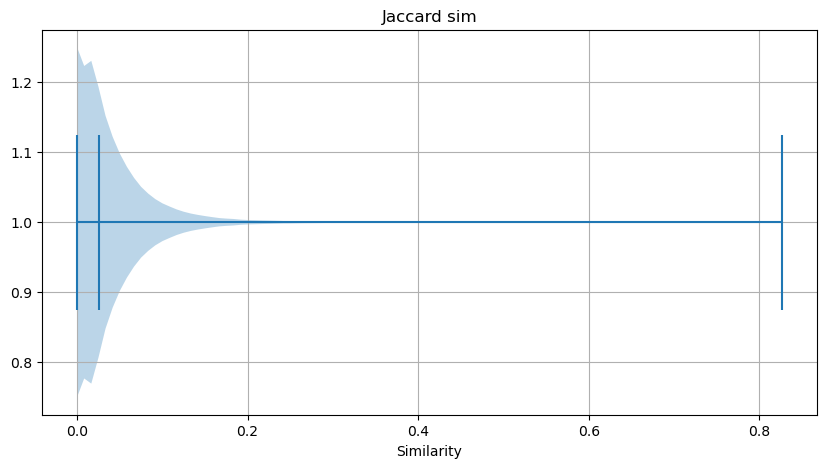

In [504]:
plot_pdf(ubcf_jacc.sim_matrix[triangle_mask], "Jaccard sim")

In [505]:
pd.Series(ubcf_jacc.sim_matrix[triangle_mask]).describe()

count    185745.000000
mean          0.041791
std           0.053541
min           0.000000
25%           0.009934
50%           0.026042
75%           0.054585
max           0.826087
dtype: float64

In [506]:
# compute recommendations for dev dataset
n_recommendations = 50
jacc_neighboar_thres = 0.1  # based on plot above

jacc_user_recommendations = {}
for user_id in tqdm(np.unique(dev_data[:, 0])):
    recommendations = ubcf_jacc.recommend(user=int(user_id), n=n_recommendations, neighboar_thres=jacc_neighboar_thres)
    
    recommended_movie_ids = menc.inverse_transform(recommendations)
    jacc_user_recommendations[uenc.inverse_transform([int(user_id)])[0]] = recommended_movie_ids

  0%|          | 0/610 [00:00<?, ?it/s]

### Jaccard similarity w/o mean correct

In [585]:
ubcf_jacc_2 = UserBasedCf(sim_fn=sim_jacc, mean_correct=False)
ubcf_jacc_2.calc_sim_matrix(train_data)

  0%|          | 0/610 [00:00<?, ?it/s]

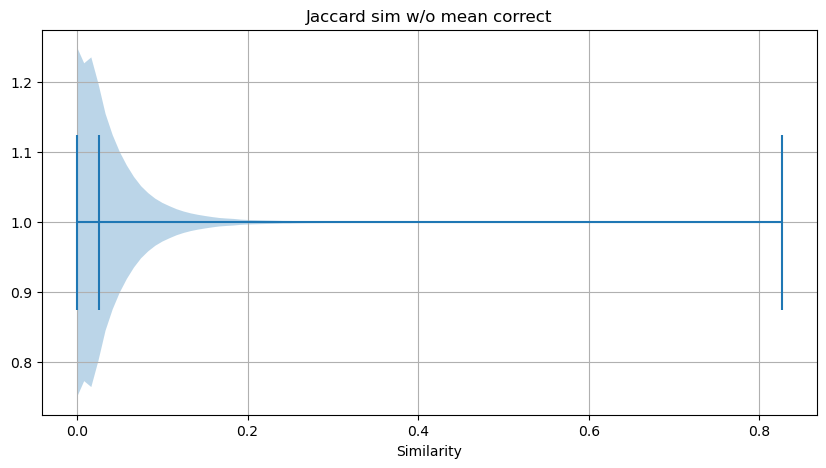

In [594]:
plot_pdf(ubcf_jacc_2.sim_matrix[triangle_mask], "Jaccard sim w/o mean correct")

In [595]:
pd.Series(ubcf_jacc_2.sim_matrix[triangle_mask]).describe()

count    185745.000000
mean          0.042011
std           0.053894
min           0.000000
25%           0.010101
50%           0.026178
75%           0.054726
max           0.826087
dtype: float64

In [596]:
# compute recommendations for dev dataset
n_recommendations = 50
jacc_2_neighboar_thres = 0.15  # based on plot above

jacc_2_user_recommendations = {}
for user_id in tqdm(np.unique(dev_data[:, 0])):
    recommendations = ubcf_jacc_2.recommend(user=int(user_id), n=n_recommendations, neighboar_thres=jacc_2_neighboar_thres)
    
    recommended_movie_ids = menc.inverse_transform(recommendations)
    jacc_2_user_recommendations[uenc.inverse_transform([int(user_id)])[0]] = recommended_movie_ids

  0%|          | 0/610 [00:00<?, ?it/s]

### Pearson correlation similarity with mean correct

In [511]:
ubcf_pear = UserBasedCf(sim_fn=sim_pearson, mean_correct=True)
ubcf_pear.calc_sim_matrix(train_data)

  0%|          | 0/610 [00:00<?, ?it/s]

/tmp/ipykernel_19386/3063891843.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sim = pearsonr(left, right)[0]


In [521]:
ubcf_pear.sim_matrix = np.nan_to_num(ubcf_pear.sim_matrix)

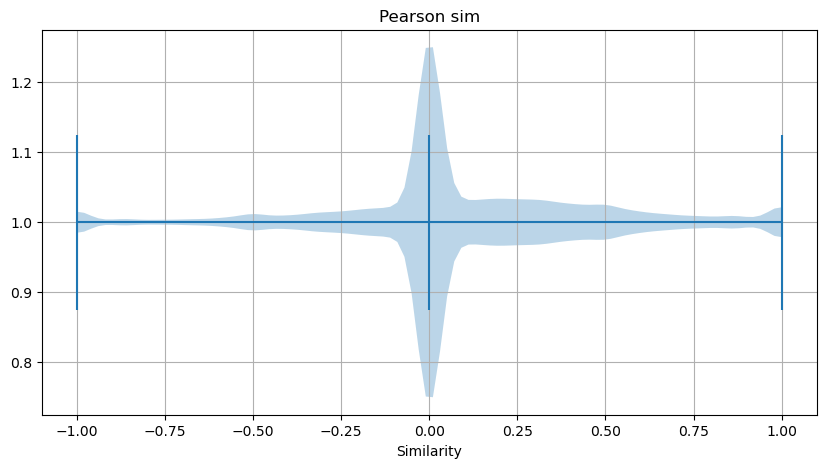

In [522]:
plot_pdf(ubcf_pear.sim_matrix[triangle_mask], "Pearson sim")

In [523]:
pd.Series(ubcf_pear.sim_matrix[triangle_mask]).describe()

count    185745.000000
mean          0.084684
std           0.386483
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.276783
max           1.000000
dtype: float64

In [530]:
# compute recommendations for dev dataset
n_recommendations = 50
pear_neighboar_thres = 0.75  # based on plot above

pear_user_recommendations = {}
for user_id in tqdm(np.unique(dev_data[:, 0])):
    recommendations = ubcf_pear.recommend(user=int(user_id), n=n_recommendations, neighboar_thres=pear_neighboar_thres)
    
    recommended_movie_ids = menc.inverse_transform(recommendations)
    pear_user_recommendations[uenc.inverse_transform([int(user_id)])[0]] = recommended_movie_ids

  0%|          | 0/610 [00:00<?, ?it/s]

### Pearson correlation similarity w/o mean correct

In [597]:
ubcf_pear_2 = UserBasedCf(sim_fn=sim_pearson, mean_correct=False)
ubcf_pear_2.calc_sim_matrix(train_data)

  0%|          | 0/610 [00:00<?, ?it/s]

/tmp/ipykernel_19386/3063891843.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sim = pearsonr(left, right)[0]


In [598]:
ubcf_pear_2.sim_matrix = np.nan_to_num(ubcf_pear_2.sim_matrix)

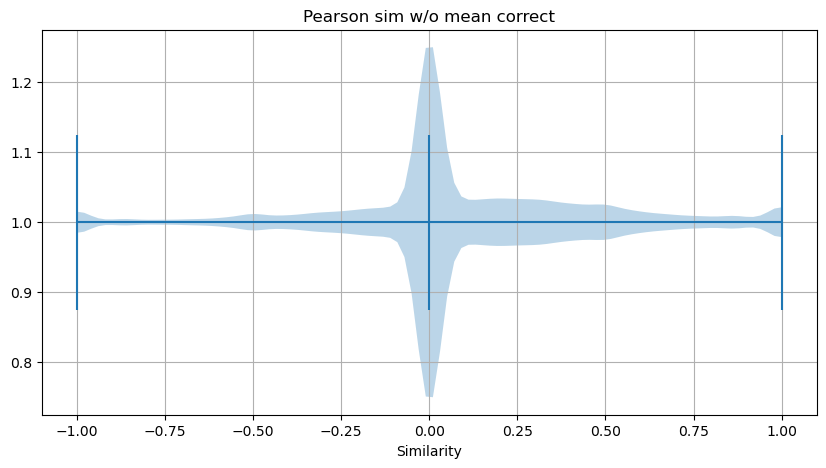

In [599]:
plot_pdf(ubcf_pear_2.sim_matrix[triangle_mask], "Pearson sim w/o mean correct")

In [600]:
pd.Series(ubcf_pear_2.sim_matrix[triangle_mask]).describe()

count    185745.000000
mean          0.084521
std           0.386689
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.277350
max           1.000000
dtype: float64

In [602]:
# compute recommendations for dev dataset
n_recommendations = 50
pear_2_neighboar_thres = 0.75  # based on plot above

pear_2_user_recommendations = {}
for user_id in tqdm(np.unique(dev_data[:, 0])):
    recommendations = ubcf_pear_2.recommend(user=int(user_id), n=n_recommendations, neighboar_thres=pear_2_neighboar_thres)
    
    recommended_movie_ids = menc.inverse_transform(recommendations)
    pear_2_user_recommendations[uenc.inverse_transform([int(user_id)])[0]] = recommended_movie_ids

  0%|          | 0/610 [00:00<?, ?it/s]

### Pearson similarity with reduction with mean correct

In [532]:
ubcf_pear_red = UserBasedCf(sim_fn=sim_pearson_decreasing, mean_correct=True)
# training
ubcf_pear_red.calc_sim_matrix(train_data)

  0%|          | 0/610 [00:00<?, ?it/s]

/tmp/ipykernel_19386/3703500813.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sim = coef * pearsonr(left, right)[0]


In [533]:
ubcf_pear_red.sim_matrix = np.nan_to_num(ubcf_pear_red.sim_matrix)

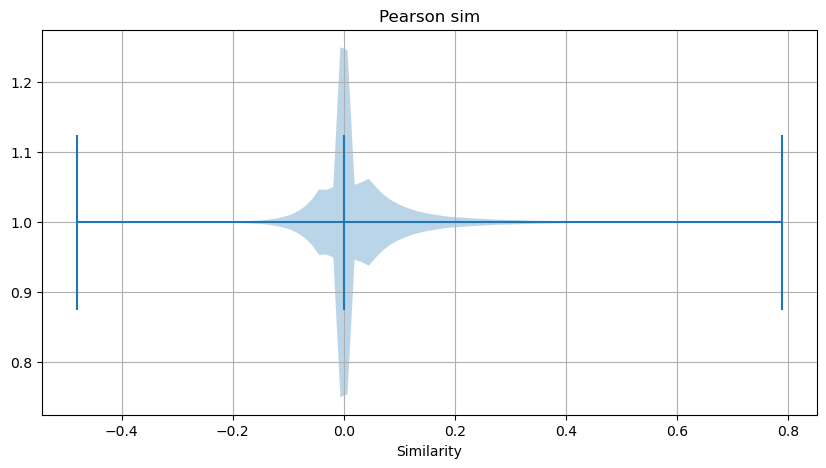

In [534]:
plot_pdf(ubcf_pear_red.sim_matrix[triangle_mask], "Pearson sim")

In [535]:
pd.Series(ubcf_pear_red.sim_matrix[triangle_mask]).describe()

count    185745.000000
mean          0.028991
std           0.088067
min          -0.480575
25%           0.000000
50%           0.000000
75%           0.052095
max           0.788457
dtype: float64

In [536]:
# compute recommendations for dev dataset
n_recommendations = 50
pear_red_neighboar_thres = 0.1  # based on plot above

pear_red_user_recommendations = {}
for user_id in tqdm(np.unique(dev_data[:, 0])):
    recommendations = ubcf_pear_red.recommend(user=int(user_id), n=n_recommendations, neighboar_thres=pear_red_neighboar_thres)
    
    recommended_movie_ids = menc.inverse_transform(recommendations)
    pear_red_user_recommendations[uenc.inverse_transform([int(user_id)])[0]] = recommended_movie_ids

  0%|          | 0/610 [00:00<?, ?it/s]

### Pearson similarity with reduction w/o mean correct

In [604]:
ubcf_pear_red_2 = UserBasedCf(sim_fn=sim_pearson_decreasing, mean_correct=False)
ubcf_pear_red_2.calc_sim_matrix(train_data)

  0%|          | 0/610 [00:00<?, ?it/s]

/tmp/ipykernel_19386/3703500813.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sim = coef * pearsonr(left, right)[0]


In [605]:
ubcf_pear_red_2.sim_matrix = np.nan_to_num(ubcf_pear_red_2.sim_matrix)

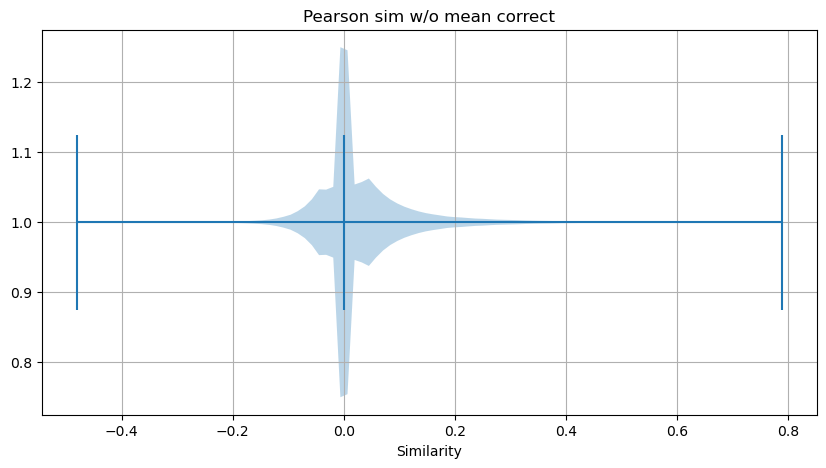

In [606]:
plot_pdf(ubcf_pear_red_2.sim_matrix[triangle_mask], "Pearson sim w/o mean correct")

In [607]:
pd.Series(ubcf_pear_red_2.sim_matrix[triangle_mask]).describe()

count    185745.000000
mean          0.029035
std           0.088165
min          -0.480575
25%           0.000000
50%           0.000000
75%           0.052449
max           0.788457
dtype: float64

In [608]:
# compute recommendations for dev dataset
n_recommendations = 50
pear_red_2_neighboar_thres = 0.2  # based on plot above

pear_red_2_user_recommendations = {}
for user_id in tqdm(np.unique(dev_data[:, 0])):
    recommendations = ubcf_pear_red_2.recommend(user=int(user_id), n=n_recommendations, neighboar_thres=pear_red_2_neighboar_thres)
    
    recommended_movie_ids = menc.inverse_transform(recommendations)
    pear_red_2_user_recommendations[uenc.inverse_transform([int(user_id)])[0]] = recommended_movie_ids

  0%|          | 0/610 [00:00<?, ?it/s]

2. Which metrics do you want to use? Why? (5 points)

The common metrics for evaluating the recsys: precision@k, recall@k, mrr and ndcg.  
Precision@k and recall@k focuses on unordered list of top recommendation and it's good base metrics, but it's don't accounting for the positions of recommendations inside top-k.  
The mrr and ndcg highly consider the position of the recommendations, showing the accuracy of ranking of our recommendations (although the mrr consider only first relevant recommendation)  
I think the most informative metric is ndcg, so i wanna calculate precision@k, recall@k and ndcg

3. Show that your implementation is relevant by computing metrics. Compare algorithms. (15 points)

In [497]:
def calculate_metrics(dev_data, user_recommendations, k, relevance_threshold):
    precision_at_k, recall_at_k, ndcg_at_k = [], [], []

    for user_id in np.unique(dev_data[:, 0]):
        user_truth = dev_data[dev_data[:, 0] == user_id]
        relevant_items = set(user_truth[user_truth[:, 2] >= relevance_threshold][:, 1])

        if not relevant_items:
            continue

        recommended_items = user_recommendations.get(user_id, [])[:k]

        # precision@k
        hits = len([item for item in recommended_items if item in relevant_items])
        precision = hits / k
        precision_at_k.append(precision)

        # recall@k
        recall = hits / len(relevant_items)
        recall_at_k.append(recall)

        # ndcg@k
        dcg, idcg = 0.0, 0.0
        for rank, item in enumerate(recommended_items, start=1):
            if item in relevant_items:
                dcg += 1 / np.log2(rank + 1)
        for rank in range(1, min(len(relevant_items), k) + 1):
            idcg += 1 / np.log2(rank + 1)
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_at_k.append(ndcg)

    mean_precision_at_k = np.mean(precision_at_k)
    mean_recall_at_k = np.mean(recall_at_k)
    mean_ndcg_at_k = np.mean(ndcg_at_k)

    return mean_precision_at_k, mean_recall_at_k, mean_ndcg_at_k

In [555]:
# dot similarity metrics with mean correct
k = 50
relevance_threshold = 4.0  # consider rating >= 4.0 as relevant

dot_mean_precision, dot_mean_recall, dot_mean_ndcg = calculate_metrics(dev_data, dot_user_recommendations, k, relevance_threshold)
print(f"Precision@{k}: {dot_mean_precision:.4f}")
print(f"Recall@{k}: {dot_mean_recall:.4f}")
print(f"NDCG@{k}: {dot_mean_ndcg:.4f}")

Precision@50: 0.0021
Recall@50: 0.0111
NDCG@50: 0.0055


In [584]:
# dot similarity metrics w/o mean correct
k = 50
relevance_threshold = 4.0  # consider rating >= 4.0 as relevant

dot_mean_precision, dot_mean_recall, dot_mean_ndcg = calculate_metrics(dev_data, dot_2_user_recommendations, k, relevance_threshold)
print(f"Precision@{k}: {dot_mean_precision:.4f}")
print(f"Recall@{k}: {dot_mean_recall:.4f}")
print(f"NDCG@{k}: {dot_mean_ndcg:.4f}")

Precision@50: 0.0022
Recall@50: 0.0135
NDCG@50: 0.0061


In [507]:
# jaccard similarity metrics with mean correct
k = 50
relevance_threshold = 4.0  # consider rating >= 4.0 as relevant

jacc_mean_precision, jacc_mean_recall, jacc_mean_ndcg = calculate_metrics(dev_data, jacc_user_recommendations, k, relevance_threshold)
print(f"Precision@{k}: {jacc_mean_precision:.4f}")
print(f"Recall@{k}: {jacc_mean_recall:.4f}")
print(f"NDCG@{k}: {jacc_mean_ndcg:.4f}")

Precision@50: 0.0032
Recall@50: 0.0216
NDCG@50: 0.0087


In [589]:
# jaccard similarity metrics w/o mean correct
k = 50
relevance_threshold = 4.0  # consider rating >= 4.0 as relevant

jacc_mean_precision, jacc_mean_recall, jacc_mean_ndcg = calculate_metrics(dev_data, jacc_2_user_recommendations, k, relevance_threshold)
print(f"Precision@{k}: {jacc_mean_precision:.4f}")
print(f"Recall@{k}: {jacc_mean_recall:.4f}")
print(f"NDCG@{k}: {jacc_mean_ndcg:.4f}")

Precision@50: 0.0023
Recall@50: 0.0160
NDCG@50: 0.0067


In [531]:
# pearson similarity metrics with mean correct
k = 50
relevance_threshold = 4.0  # consider rating >= 4.0 as relevant

pear_mean_precision, pear_mean_recall, pear_mean_ndcg = calculate_metrics(dev_data, pear_user_recommendations, k, relevance_threshold)
print(f"Precision@{k}: {pear_mean_precision:.4f}")
print(f"Recall@{k}: {pear_mean_recall:.4f}")
print(f"NDCG@{k}: {pear_mean_ndcg:.4f}")

Precision@50: 0.0017
Recall@50: 0.0092
NDCG@50: 0.0042


In [603]:
# pearson similarity metrics w/o mean correct
k = 50
relevance_threshold = 4.0  # consider rating >= 4.0 as relevant

pear_mean_precision, pear_mean_recall, pear_mean_ndcg = calculate_metrics(dev_data, pear_2_user_recommendations, k, relevance_threshold)
print(f"Precision@{k}: {pear_mean_precision:.4f}")
print(f"Recall@{k}: {pear_mean_recall:.4f}")
print(f"NDCG@{k}: {pear_mean_ndcg:.4f}")

Precision@50: 0.0018
Recall@50: 0.0079
NDCG@50: 0.0039


In [537]:
# pearson with reduction similarity metrics with mean correct
k = 50
relevance_threshold = 4.0  # consider rating >= 4.0 as relevant

pear_red_mean_precision, pear_red_mean_recall, pear_red_mean_ndcg = calculate_metrics(dev_data, pear_red_user_recommendations, k, relevance_threshold)
print(f"Precision@{k}: {pear_red_mean_precision:.4f}")
print(f"Recall@{k}: {pear_red_mean_recall:.4f}")
print(f"NDCG@{k}: {pear_red_mean_ndcg:.4f}")

Precision@50: 0.0021
Recall@50: 0.0106
NDCG@50: 0.0054


In [609]:
# pearson with reduction similarity metrics w/o mean correct
k = 50
relevance_threshold = 4.0  # consider rating >= 4.0 as relevant

pear_red_mean_precision, pear_red_mean_recall, pear_red_mean_ndcg = calculate_metrics(dev_data, pear_red_2_user_recommendations, k, relevance_threshold)
print(f"Precision@{k}: {pear_red_mean_precision:.4f}")
print(f"Recall@{k}: {pear_red_mean_recall:.4f}")
print(f"NDCG@{k}: {pear_red_mean_ndcg:.4f}")

Precision@50: 0.0020
Recall@50: 0.0107
NDCG@50: 0.0054


summary:
1. the metrics are very low, i try to use both mean_correct true and false, and different neighbor_thres
2. despite that, jaccard similarity is the most effective for this dataset
3. mean_correct=True improve performance a little in each case

# Task 4: Your favorite films

1. Choose from 10 to 50 films rated by you (you can export it from IMDB or kinopoisk) which are presented in Movielens dataset. </br> Print them in human readable form (5 points)

In [643]:
my_user_id = max(train_data[:, 0]) + 1

In [644]:
my_ratings = np.array([
    [my_user_id, 2, 4.5],
    [my_user_id, 13, 4.0],
    [my_user_id, 111, 5.0],
    [my_user_id, 231, 1.0],
    [my_user_id, 260, 5.0],
    [my_user_id, 267, 5.0],
    [my_user_id, 296, 5.0],
    [my_user_id, 318, 5.0],
    [my_user_id, 339, 2.0],
    [my_user_id, 344, 3.5],
    [my_user_id, 356, 4.5],
    [my_user_id, 364, 4.5],
    [my_user_id, 367, 3.5],
    [my_user_id, 480, 4.0],
    [my_user_id, 502, 3.0],
    [my_user_id, 519, 2.0],
    [my_user_id, 527, 5.0],
    [my_user_id, 541, 5.0],
    [my_user_id, 546, 2.0],
    [my_user_id, 592, 4.5],
    [my_user_id, 648, 4.0],
    [my_user_id, 858, 5.0],
    [my_user_id, 968, 1.0]
])
len(my_ratings)

23

In [645]:
for movie_id, rating in my_ratings[:, 1:]:
    print(f"{rating}   {movies[movies["movieId"] == movie_id].title.values[0]}, {movies[movies["movieId"] == movie_id].genres.values[0]}")

4.5   Jumanji (1995), Adventure|Children|Fantasy
4.0   Balto (1995), Adventure|Animation|Children
5.0   Taxi Driver (1976), Crime|Drama|Thriller
1.0   Dumb & Dumber (Dumb and Dumber) (1994), Adventure|Comedy
5.0   Star Wars: Episode IV - A New Hope (1977), Action|Adventure|Sci-Fi
5.0   Major Payne (1995), Comedy
5.0   Pulp Fiction (1994), Comedy|Crime|Drama|Thriller
5.0   Shawshank Redemption, The (1994), Crime|Drama
2.0   While You Were Sleeping (1995), Comedy|Romance
3.5   Ace Ventura: Pet Detective (1994), Comedy
4.5   Forrest Gump (1994), Comedy|Drama|Romance|War
4.5   Lion King, The (1994), Adventure|Animation|Children|Drama|Musical|IMAX
3.5   Mask, The (1994), Action|Comedy|Crime|Fantasy
4.0   Jurassic Park (1993), Action|Adventure|Sci-Fi|Thriller
3.0   Next Karate Kid, The (1994), Action|Children|Romance
2.0   RoboCop 3 (1993), Action|Crime|Drama|Sci-Fi|Thriller
5.0   Schindler's List (1993), Drama|War
5.0   Blade Runner (1982), Action|Sci-Fi|Thriller
2.0   Super Mario Bros. (19

2. Compute top 10 recomendations based on this films for each of 6 methods implemented. Print them in **human readable from** (5 points)

In [646]:
# add me at train dataset
train_data_w_me = np.concatenate((train_data, my_ratings), axis=0)

In [647]:
n_recommendations = 10

In [648]:
# dot product similarity with mean correct
ubcf_dot = UserBasedCf(sim_fn=sim_dot, mean_correct=True)
ubcf_dot.calc_sim_matrix(train_data_w_me)

dot_my_rec = ubcf_dot.recommend(user=int(my_user_id), 
                                n=n_recommendations, 
                                neighboar_thres=dot_neighboar_thres)
recommended_movie_ids = menc.inverse_transform(dot_my_rec)

  0%|          | 0/611 [00:00<?, ?it/s]

In [650]:
movies.loc[recommended_movie_ids, ["title", "genres"]]

,title,genres
318,I Love Trouble (1994),Action|Comedy
260,Quiz Show (1994),Drama
593,Cemetery Man (Dellamorte Dellamore) (1994),Horror
1197,In the Company of Men (1997),Comedy|Drama
2959,Billy Elliot (2000),Drama
2858,Autumn in New York (2000),Drama|Romance
1193,Event Horizon (1997),Horror|Sci-Fi|Thriller
356,"Age of Innocence, The (1993)",Drama
527,"Aristocats, The (1970)",Animation|Children
1,Jumanji (1995),Adventure|Children|Fantasy


In [652]:
# dot product similarity w/o mean correct
ubcf_dot_2 = UserBasedCf(sim_fn=sim_dot, mean_correct=False)
ubcf_dot_2.calc_sim_matrix(train_data_w_me)

dot_my_rec = ubcf_dot_2.recommend(user=int(my_user_id), 
                                n=n_recommendations, 
                                neighboar_thres=dot_2_neighboar_thres)
recommended_movie_ids_2 = menc.inverse_transform(dot_my_rec)

movies.loc[recommended_movie_ids_2, ["title", "genres"]]

  0%|          | 0/611 [00:00<?, ?it/s]

,title,genres
318,I Love Trouble (1994),Action|Comedy
356,"Age of Innocence, The (1993)",Drama
110,Jupiter's Wife (1994),Documentary
457,Romper Stomper (1992),Action|Drama
293,Underneath (1995),Mystery|Thriller
589,Last Dance (1996),Drama
480,Terminal Velocity (1994),Action|Mystery|Thriller
32,Babe (1995),Children|Drama
296,Virtuosity (1995),Action|Sci-Fi|Thriller
353,8 Seconds (1994),Drama


In [653]:
# jaccard similarity with mean correct
ubcf_jacc = UserBasedCf(sim_fn=sim_jacc, mean_correct=True)
ubcf_jacc.calc_sim_matrix(train_data_w_me)

dot_my_rec = ubcf_jacc.recommend(user=int(my_user_id), 
                                n=n_recommendations, 
                                neighboar_thres=jacc_neighboar_thres)
recommended_movie_ids_3 = menc.inverse_transform(dot_my_rec)

movies.loc[recommended_movie_ids_3, ["title", "genres"]]

  0%|          | 0/611 [00:00<?, ?it/s]

,title,genres
1356,Zero Effect (1998),Comedy|Mystery|Thriller
780,Cinderella (1950),Animation|Children|Fantasy|Musical|Romance
736,Penny Serenade (1941),Drama|Romance
626,Daylight (1996),Action|Adventure|Drama|Thriller
619,"Cable Guy, The (1996)",Comedy|Thriller
116,"Birdcage, The (1996)",Comedy
68,Screamers (1995),Action|Sci-Fi|Thriller
62,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
40,Mortal Kombat (1995),Action|Adventure|Fantasy


In [656]:
# jaccard similarity w/o mean correct
ubcf_jacc_2 = UserBasedCf(sim_fn=sim_jacc, mean_correct=False)
ubcf_jacc_2.calc_sim_matrix(train_data_w_me)

dot_my_rec = ubcf_jacc_2.recommend(user=int(my_user_id), 
                                n=n_recommendations, 
                                neighboar_thres=0.1)
recommended_movie_ids_4 = menc.inverse_transform(dot_my_rec)

movies.loc[recommended_movie_ids_4, ["title", "genres"]]

  0%|          | 0/611 [00:00<?, ?it/s]

,title,genres
1356,Zero Effect (1998),Comedy|Mystery|Thriller
780,Cinderella (1950),Animation|Children|Fantasy|Musical|Romance
736,Penny Serenade (1941),Drama|Romance
626,Daylight (1996),Action|Adventure|Drama|Thriller
619,"Cable Guy, The (1996)",Comedy|Thriller
116,"Birdcage, The (1996)",Comedy
68,Screamers (1995),Action|Sci-Fi|Thriller
62,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
40,Mortal Kombat (1995),Action|Adventure|Fantasy
648,Chain Reaction (1996),Action|Adventure|Thriller


In [658]:
# pearson correlation with mean correct
ubcf_pear = UserBasedCf(sim_fn=sim_pearson, mean_correct=True)
ubcf_pear.calc_sim_matrix(train_data_w_me)
ubcf_pear.sim_matrix = np.nan_to_num(ubcf_pear.sim_matrix)

dot_my_rec = ubcf_pear.recommend(user=int(my_user_id), 
                                n=n_recommendations, 
                                neighboar_thres=pear_neighboar_thres)
recommended_movie_ids_5 = menc.inverse_transform(dot_my_rec)

movies.loc[recommended_movie_ids_5, ["title", "genres"]]

  0%|          | 0/611 [00:00<?, ?it/s]

/tmp/ipykernel_19386/3063891843.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sim = pearsonr(left, right)[0]


,title,genres
318,I Love Trouble (1994),Action|Comedy
356,"Age of Innocence, The (1993)",Drama
110,Jupiter's Wife (1994),Documentary
1,Jumanji (1995),Adventure|Children|Fantasy
593,Cemetery Man (Dellamorte Dellamore) (1994),Horror
1197,In the Company of Men (1997),Comedy|Drama
608,Heavy (1995),Drama|Romance
1265,Sliding Doors (1998),Drama|Romance
2571,Teenage Mutant Ninja Turtles II: The Secret of...,Action|Children|Fantasy
2858,Autumn in New York (2000),Drama|Romance


In [660]:
# pearson correlation w/o mean correct
ubcf_pear_2 = UserBasedCf(sim_fn=sim_pearson, mean_correct=False)
ubcf_pear_2.calc_sim_matrix(train_data_w_me)
ubcf_pear_2.sim_matrix = np.nan_to_num(ubcf_pear_2.sim_matrix)

dot_my_rec = ubcf_pear_2.recommend(user=int(my_user_id), 
                                n=n_recommendations, 
                                neighboar_thres=pear_2_neighboar_thres)
recommended_movie_ids_6 = menc.inverse_transform(dot_my_rec)

movies.loc[recommended_movie_ids_6, ["title", "genres"]]

  0%|          | 0/611 [00:00<?, ?it/s]

/tmp/ipykernel_19386/3063891843.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sim = pearsonr(left, right)[0]


,title,genres
356,"Age of Innocence, The (1993)",Drama
318,I Love Trouble (1994),Action|Comedy
457,Romper Stomper (1992),Action|Drama
480,Terminal Velocity (1994),Action|Mystery|Thriller
110,Jupiter's Wife (1994),Documentary
150,Love & Human Remains (1993),Comedy|Drama
593,Cemetery Man (Dellamorte Dellamore) (1994),Horror
296,Virtuosity (1995),Action|Sci-Fi|Thriller
380,Color of Night (1994),Drama|Thriller
364,Beverly Hills Cop III (1994),Action|Comedy|Crime|Thriller


In [661]:
# pearson correlation with reduction with mean correct
ubcf_pear_red = UserBasedCf(sim_fn=sim_pearson_decreasing, mean_correct=True)
ubcf_pear_red.calc_sim_matrix(train_data_w_me)
ubcf_pear_red.sim_matrix = np.nan_to_num(ubcf_pear_red.sim_matrix)

dot_my_rec = ubcf_pear_red.recommend(user=int(my_user_id), 
                                n=n_recommendations, 
                                neighboar_thres=pear_red_neighboar_thres)
recommended_movie_ids_7 = menc.inverse_transform(dot_my_rec)

movies.loc[recommended_movie_ids_7, ["title", "genres"]]

  0%|          | 0/611 [00:00<?, ?it/s]

/tmp/ipykernel_19386/3703500813.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sim = coef * pearsonr(left, right)[0]


,title,genres
1197,In the Company of Men (1997),Comedy|Drama
1079,Marvin's Room (1996),Drama
1527,"Parent Trap, The (1998)",Children|Comedy|Romance
2959,Billy Elliot (2000),Drama
2968,Little Nicky (2000),Comedy
2987,"Bounty, The (1984)",Adventure|Drama
2723,Blow-Out (La grande bouffe) (1973),Drama
3070,Ishtar (1987),Comedy
3358,Without a Clue (1988),Comedy|Mystery
1285,Home Alone 3 (1997),Children|Comedy


In [662]:
# pearson correlation with reduction w/o mean correct
ubcf_pear_red_2 = UserBasedCf(sim_fn=sim_pearson_decreasing, mean_correct=False)
ubcf_pear_red_2.calc_sim_matrix(train_data_w_me)
ubcf_pear_red_2.sim_matrix = np.nan_to_num(ubcf_pear_red_2.sim_matrix)

  0%|          | 0/611 [00:00<?, ?it/s]

/tmp/ipykernel_19386/3703500813.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sim = coef * pearsonr(left, right)[0]


,title,genres


In [663]:
dot_my_rec = ubcf_pear_red_2.recommend(user=int(my_user_id), 
                                n=n_recommendations, 
                                neighboar_thres=0.1)
recommended_movie_ids_8 = menc.inverse_transform(dot_my_rec)

movies.loc[recommended_movie_ids_8, ["title", "genres"]]

,title,genres
1197,In the Company of Men (1997),Comedy|Drama
1079,Marvin's Room (1996),Drama
551,James and the Giant Peach (1996),Adventure|Animation|Children|Fantasy|Musical
1097,Zeus and Roxanne (1997),Children
1291,Titanic (1997),Drama|Romance
260,Quiz Show (1994),Drama
1269,Mrs. Dalloway (1997),Drama|Romance
1193,Event Horizon (1997),Horror|Sci-Fi|Thriller
1219,Seven Years in Tibet (1997),Adventure|Drama|War
1234,"Mrs. Brown (a.k.a. Her Majesty, Mrs. Brown) (1...",Drama|Romance


3. Rate films that was recommended in previous step (by title, description, trailer). For each algorithm compute metrics based on ratings you put.

In [666]:
# i choose rec list from method based on pearson correlation similarity  
# with decreasing factor on small intersection with mean_correct=True
my_ratings_on_rec_films = np.array([
    [my_user_id, 1197, 4.5],
    [my_user_id, 1079, 3.0],
    [my_user_id, 551, 4.0],
    [my_user_id, 1097, 3.5],
    [my_user_id, 1291, 5.0],
    [my_user_id, 260, 4.0],
    [my_user_id, 1269, 1.0],
    [my_user_id, 1193, 5.0],
    [my_user_id, 1219, 4.5],
    [my_user_id, 1234, 2.0],
])

k = 10
# compute metrics
prec, rec, ndcg = calculate_metrics(my_ratings_on_rec_films, 
                                  {my_user_id: recommended_movie_ids_8}, 
                                  k, 
                                  relevance_threshold=4.0)
print(f"Precision@{k}: {prec:.4f}")
print(f"Recall@{k}: {rec:.4f}")
print(f"NDCG@{k}: {ndcg:.4f}")

Precision@10: 0.6000
Recall@10: 1.0000
NDCG@10: 0.8653


# Task 5: Conclusion (10 points)

Compare all methods based on both dataset (metrics) and your personal recomendations.

Which algorithm is the best? Why?

Was recommedations different? Which set of recomendations you like the most?

What differences in algorithms have you noted?

On dataset i have low perfornamce metrics on all methods. But the method based on Jaccard similarity have the biggest metrics. 

On my personal recommendation the method based on Pearson correlation similarity with decreasing factor is the best. And the recommended movies are quite good and matches with me, also the recommended movie's genres is quite good matches with what i set as my user vector.

For user2user rec systems, for the methods i consider in this HW:
1. Pearson correlation is the most effective, as it adjusts for individual user biases and captures similarity in rating trends. 
2. Jaccard similarity i think have limitation with type of targets it's working and it is probably best for binary data (f.e. seen\don't seen). 
3. Dot product is very fast to calculate (compare to perason correlation) but it has some issues with dependancies at popularity of items or most active users. In this cases the magnitudes of vectors will be much greater - and the whole system will be tend to predict the most popular movies or predict movies which watched the most active users. And it will be hard to recommend some new, unique content. 

Additionally, i should be try cosine similarity because it measures angle-based similarity in high-dimensional spaces and it effectively captures the direction, not considering the magnitude differences. And in high-dim spaces the direction is frequently explain the semantic meaning, while the magnitude - the popularity.